## Data Preprocessing Steps

### Type 1 (in accordance with torch.hub)
1. Get basic shapes (#=51, centered by centroid) and their rotations (from 1-8).
2. Scale s.t. in interval [0, 1].
3. Normalize to mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225].
4. Adjust according to light or dark: dark = 2*mean - light. This reflects light w.r.t. the mean
5. Adjust according to scale: out_array = (1-scale)\*mean + scale*in_array.

### Type 2
1. Get basic shapes (#=51, centered by centroid) and their rotations (from 1-8).
2. Scale s.t. in interval [0, 1].
3. Adjust according to light or dark: dark = light*(-1).
4. Adjust according to scale: out_array = in_array*scale.

Type 2 ended up having slightly better results (in terms of invariance) for AN. Therefore, most of the analysis here uses the Type 2 preprocessing step.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import handytools.navigator as nav
import handytools.visualizer as vis
import handytools.manipulator as man
import spectools.basics as bcs
from spectools.metrics.metrics import response_sparsity # Not used because it doesn't seem to make too much of a difference?

In [54]:
preprocess = 2

## Fill-Outline Invariance

**Fill-outline invariance** (FOI) means that the unit is sensitive only to the boundary curvature at a certain spatial orientation, and not to the texture of the object. For a perfectly invariant unit, its response $R(\cdot)$ should be the same given a hollow or filled closed shape. We will denote that as:

\begin{equation}
R(s_h) = R(s_f)
\end{equation}

The degree in which a unit is FOI is defined as its r-squared value, which is:
\begin{equation*}
r^2 = 1 - \frac{MSE(R(s_h), R(s_f))}{\sigma(R(s_h))\sigma(R(s_f))},
\end{equation*}
where $MSE$ is the mean-square error (i.e. the deviation from Eq 1), and $\sigma(\cdot)$ is the standard deviation of a random variable, used to normalize $MSE$. Note that this definition is slightly different from the normal r-squared definition, where the normalization term is instead the variance of the dependent variable. Since there is no clear dependent and independent variable in our case, I used this definition for symmetry purposes.

### An Example

In [55]:
# helpful functions

def get_dict(keys, values):
    """Create dictionary based on keys, values."""
    dic = {}
    for i, key in enumerate(keys): dic[key] = values[i]
    return dic

def get_r2(datatype, mtype, key, preprocess):
    """Get filtered r-squared values (i.e. ReLU(r2))."""
    metrics = nav.pklload("/src", "results", f"{datatype}_{mtype}", f"key={key}_preproc={preprocess}", "fit_metrics.pkl")
    metrics_array = np.asarray(list(metrics.values())) # shape = (# responsive units, # metrics)
    r2_filtered = np.maximum(metrics_array[:,2], 0) # ReLU(r^2)
    return r2_filtered, list(metrics.keys()), get_dict(list(metrics.keys()), r2_filtered)

In [56]:
# helpful functions

def plot_invariance(R1, R2, s2, title, xlabel, ylabel, ax=None):
    if ax == None: ax = plt.figure().add_subplot(111)
    ax.scatter(R1[s2], R2[s2], color="b")
    minn = min([min(R1[s2]), min(R2[s2])])
    maxx = max([max(R1[s2]), max(R2[s2])])
    ax.plot([minn, maxx], [minn, maxx], "k--") # plot x=y
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title) 

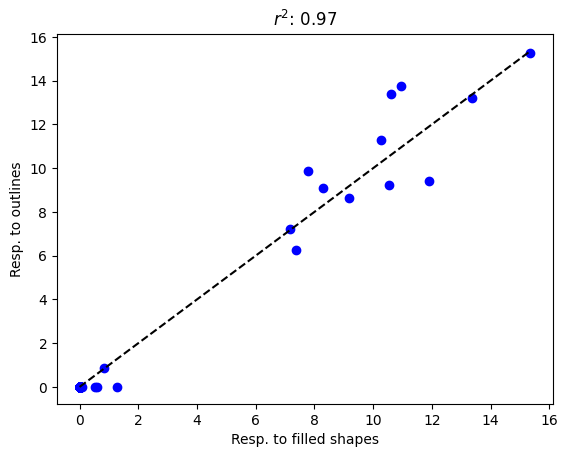

In [57]:
# Plot response to filled shape vs. outline of the unit with highest FOI in layer 8 of the AN

R_fill = nav.npload("/src", "results", f"responses_AN", f"key=8_hollow=0_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_holl = nav.npload("/src", "results", f"responses_AN", f"key=8_hollow=1_scale=1_light=1_lw=1_preproc={preprocess}.npy")
r2, idx, _ = get_r2("FOI", "AN", 8, preprocess)

s1 = list(r2).index(max(r2))
s2 = idx[s1]
plot_invariance(R_fill, R_holl, s2, f"$r^2$: {round(r2[s1],2)}", "Resp. to filled shapes", "Resp. to outlines")

### AlexNet

Plot average FOI as a function of layer. The layers chosen are either convolutional or linear layers.

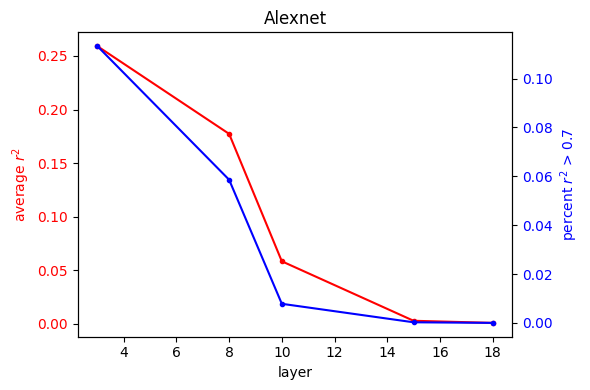

In [58]:
avg_r2, perc_r2 = [], []
layers = [3,8,10,15,18]

for hk in layers:
    r2 = get_r2("FOI", "AN", hk, preprocess)[0]
    nunits = bcs.infer_nunits(len(r2))
    avg_r2.append(np.mean(r2))
    perc_r2.append(sum(r2 >= 0.7)/nunits)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(layers, avg_r2, "r.", linestyle="-")
ax1.set_xlabel('layer'); ax1.set_ylabel('average $r^2$', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()
ax2.plot(layers, perc_r2, "b.", linestyle="-")
ax2.set_xlabel('layer'); ax2.set_ylabel('percent $r^2$ > 0.7', color="b")
ax2.tick_params(axis='y', labelcolor="b")

plt.title("Alexnet")
plt.tight_layout(); plt.show()

### VGG 16

Similar to above.

Text(0.5, 1.0, 'VGG 16')

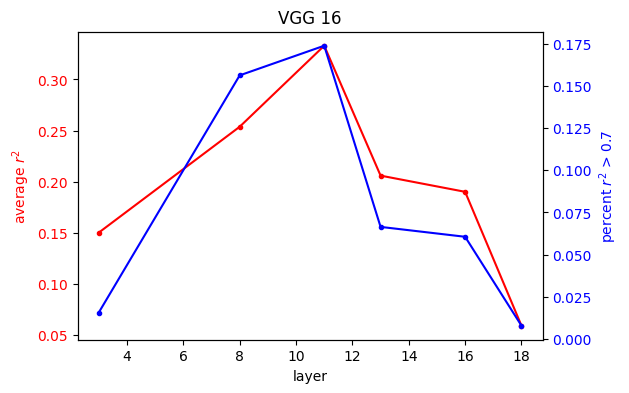

In [59]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

for hk in layers:
    r2 = get_r2("FOI", "VGG16", hk, preprocess)[0]
    nunits = bcs.infer_nunits(len(r2))
    avg_r2.append(np.mean(r2))
    perc_r2.append(sum(r2 >= 0.7)/nunits)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(layers, avg_r2, "r.", linestyle="-")
ax1.set_xlabel('layer'); ax1.set_ylabel('average $r^2$', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()
ax2.plot(layers, perc_r2, "b.", linestyle="-")
ax2.set_xlabel('layer'); ax2.set_ylabel('percent $r^2$ > 0.7', color="b")
ax2.tick_params(axis='y', labelcolor="b")

plt.title("VGG 16")

## On-Off Invariance vs. Fill-Outline Invariance

On-Off Invariance (OOI) can be defined in a similar way as FOI. Is fill-outline invariance correlated with on-off invariance? That is, are the units that are FOI also OOI?

### Alexnet

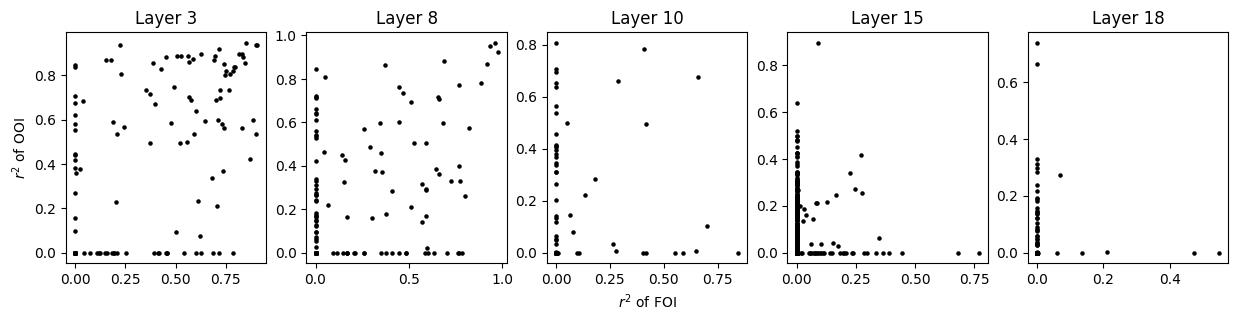

In [61]:
avg_r2, perc_r2 = [], []
layers = [3,8,10,15,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi, foi_dic = get_r2("FOI", "AN", hk, preprocess)
    r2_ooi, idx_ooi, ooi_dic = get_r2("OOI", "AN", hk, preprocess)
    new_dic = man.combine_dict(foi_dic, ooi_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)
    ax.set_title(f"Layer {hk}")
vis.common_label(fig, "$r^2$ of FOI", "$r^2$ of OOI")

### VGG16

Similar to above.

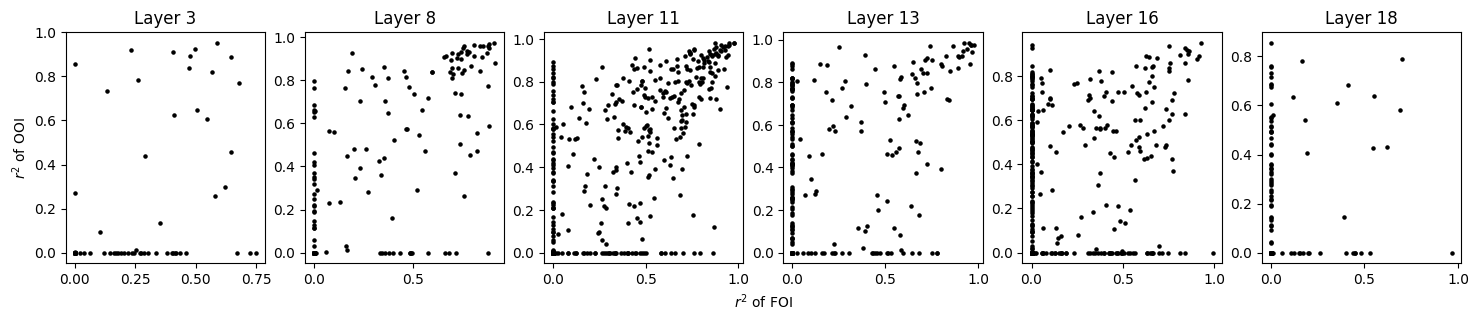

In [62]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi, foi_dic = get_r2("FOI", "VGG16", hk, preprocess)
    r2_ooi, idx_ooi, ooi_dic = get_r2("onoff", "VGG16", hk, preprocess)
    new_dic = man.combine_dict(foi_dic, ooi_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)
    ax.set_title(f"Layer {hk}")
vis.common_label(fig, "$r^2$ of FOI", "$r^2$ of OOI")

## Dynamic Range Invariance vs. Fill-Outline Invariance

Is fill-outline invariance correlated with dynamic range invariance (DRI)?

### VGG16

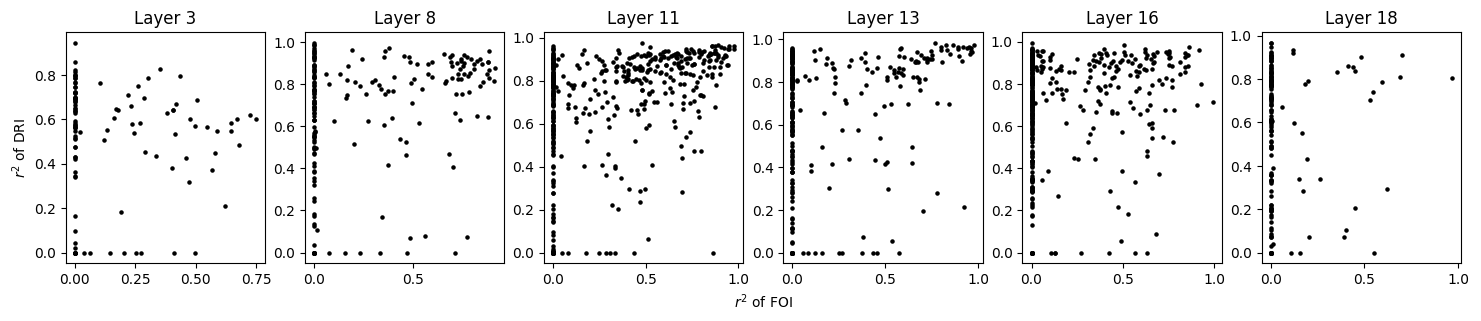

In [63]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi, foi_dic = get_r2("FOI", "VGG16", hk, preprocess)
    r2_dri, idx_dri, dri_dic = get_r2("DRI", "VGG16", hk, preprocess)
    new_dic = man.combine_dict(foi_dic, dri_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)
    ax.set_title(f"Layer {hk}")
vis.common_label(fig, "$r^2$ of FOI", "$r^2$ of DRI")

## Highly Invariant Units

The unit with highest invariance (averaged over FOI, OOI and DRI) is plotted.

In [69]:
thre = 0.85
hk = 11

r2_foi, idx_foi, foi_dic = get_r2("FOI", "VGG16", hk, preprocess)
r2_ooi, idx_ooi, ooi_dic = get_r2("OOI", "VGG16", hk, preprocess)
r2_dri, idx_dri, dri_dic = get_r2("DRI", "VGG16", hk, preprocess)
new_dic = man.combine_dict(foi_dic, ooi_dic, dri_dic)

compare = []
for key, val in new_dic.items():
    if np.all(np.array(val) > thre):
        compare.append((sum(val), *val, key))
compare = sorted(compare, reverse=True)
unit = compare[0][-1] # highly invariant unit
print(f"Unit is: {unit}, the r-squared values are: {compare[0][1:-1]}")

Unit is: 435, the r-squared values are: (0.975986797362566, 0.9810156673192978, 0.9592484198510647)


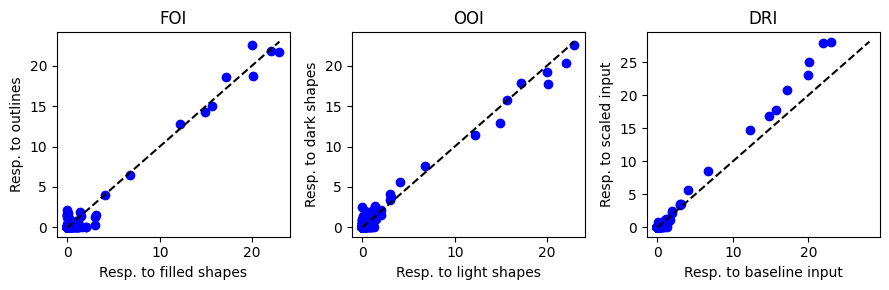

In [65]:
R_fill = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=0_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_holl = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=1_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_light = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=0_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_dark = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=0_scale=1_light=0_lw=1_preproc={preprocess}.npy")
R_baseline = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=0_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_scaled = nav.npload("/src", "results", f"responses_VGG16", f"key=11_hollow=0_scale=2_light=1_lw=1_preproc={preprocess}.npy")

fig, axs = plt.subplots(1, 3, figsize=(9,3))
plot_invariance(R_fill, R_holl, unit, "FOI", "Resp. to filled shapes", "Resp. to outlines", ax=axs[0])
plot_invariance(R_light, R_dark, unit, "OOI", "Resp. to light shapes", "Resp. to dark shapes", ax=axs[1])
plot_invariance(R_baseline, R_scaled, unit, "DRI", "Resp. to baseline input", "Resp. to scaled input", ax=axs[2])
plt.tight_layout()

## Future Directions

### DRI
1. Perform DRI on AN
2. Try different scaling for obtaining DRI (It seems like it's easy to obtain DRI using the current scaling value)

### Mechanisms
1. What are these highly invariant units doing?

### Other Nets
1. Code up ResNet